# Skin Cancer Image Classification

## 1. Overview

## 2. Business Understanding

According to [American Academy of Dermatology](https://www.aad.org/media/stats-skin-cancer), skin cancer is the most commonly diagnosed cancer in the United States. Almost 9,500 people in US are diagnosed with skin cancer everyday, and it is estimated that 25% of the Americans will develop skin cancer in their lifetime. The vast mojority of the skin cancer deaths are from melanoma.  However, if the melanoma is detected and treated early, before it spreads to lymph nodes, the survaival rate is as high as 99%. This indicates the importance of early diagnosis of melanoma for skin cancer patients. 

On the other hand, the number of unnecessary biopsies for melanoma detection varies between 83% to 96% according to [Assessment of Raman Spectroscopy for Reducing Unnecessary Biopsies for Melanoma Screening](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7355922/) article. These unnecessary biopsies challenges both patients and healtcare system financially. It is important to improve the accuracy of melanoma diagnosis to reduce financial burden.     

In this project, I would like to construct a neural network model to predict whether a skin lesion image is malignant (melanoma) or benign by using artificial intelligence algorithms. The final model of this project will be used as a decision support tool by dermatologists and/or medical professionals. When assessing the model, I will use **recall** and **accuracy** metrics. The false negative in this context is classifying an image as benign when it actually is malignant. In the final model, I would like the reduce the false negetives so that I will judge the model by recall metric along with the accuracy since I also want to predict all the lesions accurately. 

## 3. Data Understanding

The data comes from the International Skin Imaging Collaboration (ISIC) archive. The archive serves as an open resource for public for teaching and research purposes. ISIC hosts challenges in order to facilitate the application of digital skin imaging to help reduce the melonoma mortality. In this project, I will use [ISIC 2020 challenge](https://challenge2020.isic-archive.com/) dataset, [ISIC 2019 challenge](https://challenge2019.isic-archive.com/) dataset, and additional new never seen before malignant images from [ISIC archive](https://www.isic-archive.com/#!/topWithHeader/onlyHeaderTop/gallery?filter=%5B%5D) to classify benign vs. malignant images. Each dataset contains dermoscopic images of unique benign and malignant skin lesions along with metadata info of patient's age, sex, and anatomic location of the lesion.

In the ISIC 2020 challenge dataset there is a class imbalance problem, while 99% of the images are from benign category, only 1% of the images are from malignant category. After downsampling benign class and upsampling malignant class by adding additional malignant images from ISIC 2019 challenge and ISIC archive, the final dataset has total number of **12,436** images where 6750 of them are benign and 5686 of them are malignant. This final dataset has more balanced classes with 54% benign and 46% malignant image distribution. 

Since all the neural network models in this project are run on a local computer, in order to reduce preprocessing time the 512x512 resized images are used in the final dataset. Resized image sources are from Kaggle Grandmaster Chris Deotte's website: [1](https://www.kaggle.com/cdeotte/jpeg-melanoma-512x512?select=train.csv), [2](https://www.kaggle.com/cdeotte/jpeg-isic2019-512x512), [3](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/169139).  

  


In [1]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(123)

In [3]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

In [4]:
!ls data/ISIC_IMAGES_512x512/

ADD_ISIC
ISIC2019
ISIC2020


In [5]:
# define datasets
df2020 = pd.read_csv('data/ISIC_IMAGES_512x512/ISIC2020/train2020.csv')
df2019 = pd.read_csv('data/ISIC_IMAGES_512x512/ISIC2019/train2019.csv')
dfAdd = pd.read_csv('data/ISIC_IMAGES_512x512/Add_ISIC/train_add.csv')

In [6]:
# define the file path
data2020_dir = 'data/ISIC_IMAGES_512x512/ISIC2020/image2020/'
data2019_dir = 'data/ISIC_IMAGES_512x512/ISIC2019/image2019/'
dataAdd_dir = 'data/ISIC_IMAGES_512x512/Add_ISIC/image_add/'

### ISIC - 2020 DATASET

In [7]:
df2020

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000
...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,2,2592,1936
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,11,6000,4000
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,3,1872,1053
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,11,1872,1053


In [8]:
df2020['benign_malignant'].value_counts(normalize=True)

benign       0.98237
malignant    0.01763
Name: benign_malignant, dtype: float64

ISIC 2020 Challenge dataset has class imbalance issue. I will downsample majority class (benign) and upsample minority class (malignant) by adding additional malignant images in order to solve class imbalance problem in the dataset.

Let's first add image path to the metadata frame by creating path column:

In [9]:
# Add image's path data to metadata frame:
df2020['path'] = data2020_dir + df2020['image_name'] + ".jpg"
df2020.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...


In [10]:
# Define benign dataframe:
df2020_benign = df2020[df2020['benign_malignant'] == 'benign']
df2020_benign

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
...,...,...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,2,2592,1936,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,11,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,3,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,11,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...


In [11]:
# Define malignant dataframe:
df2020_malignant = df2020[df2020['benign_malignant'] == 'malignant']
df2020_malignant

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,5,3264,2448,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,3,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,9,4288,2848,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,10,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
...,...,...,...,...,...,...,...,...,...,...,...,...
32969,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1,5,640,480,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
33000,ISIC_9963177,IP_1165806,male,70.0,torso,melanoma,malignant,1,13,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
33014,ISIC_9967383,IP_7887363,male,60.0,upper extremity,melanoma,malignant,1,-1,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...
33050,ISIC_9978107,IP_2860540,male,65.0,lower extremity,melanoma,malignant,1,6,4288,2848,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...


In [12]:
# Downsample benign images to top 6750 images:
df2020_benign_sample = df2020_benign[:6750]

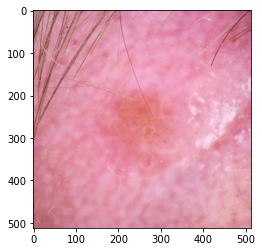

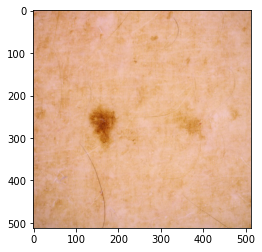

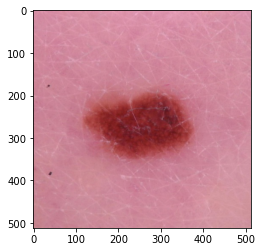

In [13]:
# look into 3 benign image samples from df2020:
for im in df2020_benign_sample['path'][0:3]:
    img = mpimg.imread(im)
    imgplot = plt.imshow(img)
    plt.show()

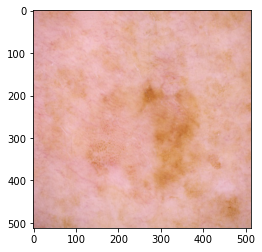

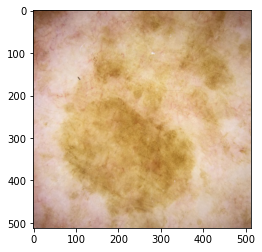

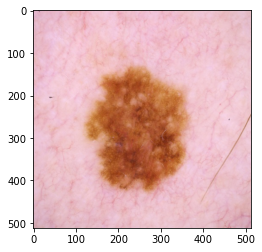

In [14]:
# look into 3 malignant image samples from df2020:
for im in df2020_malignant['path'][:3]:
    img = mpimg.imread(im)
    imgplot = plt.imshow(img)
    plt.show()

### ISIC - 2019 DATASET

In [15]:
df2019

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767
...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,-1,female,85.0,head/neck,BCC,benign,0,19,1024,1024
25327,ISIC_0073248,-1,male,65.0,anterior torso,BKL,benign,0,7,1024,1024
25328,ISIC_0073249,-1,male,70.0,lower extremity,MEL,malignant,1,9,1024,1024
25329,ISIC_0073251,-1,female,55.0,palms/soles,NV,benign,0,15,1024,1024


In [16]:
df2019['benign_malignant'].value_counts()

benign       20809
malignant     4522
Name: benign_malignant, dtype: int64

There are 4522 malignant images from ISIC 2019 challenge dataset that will be used to upsample minority class in the project's dataset. Before upsampling, let's first add image path to the metadata frame.

In [17]:
# add image's path data to metadata frame:
df2019['path'] = data2019_dir + df2019['image_name'] + ".jpg"
df2019.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...


In [18]:
# Define malignant dataframe:
df2019_mal = df2019[df2019['benign_malignant'] == 'malignant']
df2019_mal

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
12,ISIC_0000013,-1,female,30.0,posterior torso,MEL,malignant,1,20,1022,767,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
21,ISIC_0000022_downsampled,-1,female,55.0,lower extremity,MEL,malignant,1,14,1024,768,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
25,ISIC_0000026_downsampled,-1,female,30.0,lower extremity,MEL,malignant,1,14,1024,768,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
...,...,...,...,...,...,...,...,...,...,...,...,...
25316,ISIC_0073231,-1,female,55.0,anterior torso,MEL,malignant,1,17,1024,1024,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
25319,ISIC_0073237,-1,female,45.0,lower extremity,MEL,malignant,1,11,1024,1024,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
25320,ISIC_0073238,-1,female,45.0,upper extremity,MEL,malignant,1,11,1024,1024,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...
25322,ISIC_0073241,-1,male,60.0,palms/soles,MEL,malignant,1,13,1024,1024,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...


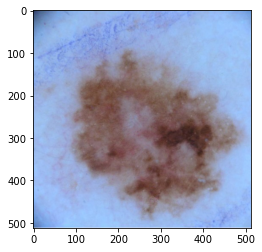

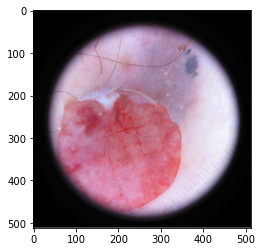

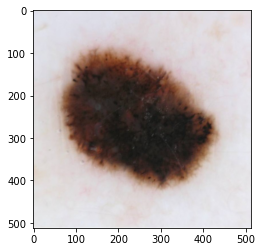

In [19]:
# look into 3 malignant image samples from df2019:
for im in df2019_mal['path'][:3]:
    img = mpimg.imread(im)
    imgplot = plt.imshow(img)
    plt.show()

### ISIC ARCHIVE ADDITIONAL MALIGNANT DATASET

In [20]:
dfAdd

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,width,height,source,ext,tfrecord
0,ISIC_0000070,-1,male,25.0,anterior torso,melanoma,malignant,1,1022,767,UDA-1,jpg,15
1,ISIC_0000076,-1,male,55.0,posterior torso,melanoma,malignant,1,1504,1129,UDA-1,jpg,15
2,ISIC_0000144,-1,NaN,NaN,NaN,melanoma,malignant,1,2048,1536,UDA-1,jpg,15
3,ISIC_0000158,-1,female,30.0,upper extremity,melanoma,malignant,1,722,542,UDA-1,jpg,15
4,ISIC_0000284,-1,male,80.0,head/neck,melanoma,malignant,1,1024,768,UDA-1,jpg,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,3008,2000,2018 JID Editorial Images,jpg,29
576,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,3008,2000,2018 JID Editorial Images,jpg,29
577,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,3008,2000,2018 JID Editorial Images,jpg,29
578,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,4288,2848,2018 JID Editorial Images,jpg,29


In [21]:
dfAdd['benign_malignant'].value_counts()

malignant    580
Name: benign_malignant, dtype: int64

This dataset only includes malignant images that are not used either ISIC 2020 challenge or ISIC 2019 challenge.

In [22]:
# Add image's path data to the metadata frame:
dfAdd['path'] = dataAdd_dir + dfAdd['image_name'] + ".jpg"
dfAdd.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,width,height,source,ext,tfrecord,path
0,ISIC_0000070,-1,male,25.0,anterior torso,melanoma,malignant,1,1022,767,UDA-1,jpg,15,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...
1,ISIC_0000076,-1,male,55.0,posterior torso,melanoma,malignant,1,1504,1129,UDA-1,jpg,15,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...
2,ISIC_0000144,-1,NaN,NaN,NaN,melanoma,malignant,1,2048,1536,UDA-1,jpg,15,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...
3,ISIC_0000158,-1,female,30.0,upper extremity,melanoma,malignant,1,722,542,UDA-1,jpg,15,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...
4,ISIC_0000284,-1,male,80.0,head/neck,melanoma,malignant,1,1024,768,UDA-1,jpg,15,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...


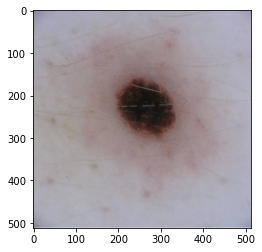

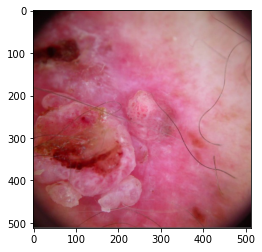

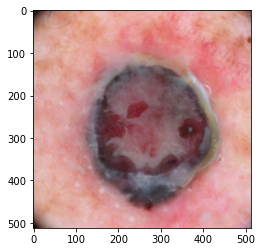

In [23]:
# look into 3 malignant image samples from additional dataset, dfAdd:
for im in dfAdd['path'][:3]:
    img = mpimg.imread(im)
    imgplot = plt.imshow(img)
    plt.show()

### Final Dataset

In the final dataset, we will use 6750 benign images from ISIC 2020 challenge dataset, and all malignant images from ISIC 2020, ISIC 2019 challenges, and additional archive malignant images.

In [24]:
df_final = pd.concat([df2020_benign_sample, df2020_malignant, df2019_mal, dfAdd], axis=0, ignore_index= True)
df_final

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12431,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg
12432,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg
12433,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg
12434,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg


In [25]:
df_final['benign_malignant'].value_counts()

benign       6750
malignant    5686
Name: benign_malignant, dtype: int64

In [26]:
df_final['benign_malignant'].value_counts(normalize=True)

benign       0.542779
malignant    0.457221
Name: benign_malignant, dtype: float64

The final dataset has more balanced classes, it has 6750 images for benign class and 5686 images for malignant class.

## 4. Exploratory Data Analysis

In [27]:
# Create a copy of df_final for EDA purposes:
df_copy = df_final[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge', 'benign_malignant']]
df_copy

,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
0,ISIC_2637011,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,45.0,head/neck,benign
1,ISIC_0015719,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,45.0,upper extremity,benign
2,ISIC_0052212,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,50.0,lower extremity,benign
3,ISIC_0068279,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,45.0,head/neck,benign
4,ISIC_0074268,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,55.0,upper extremity,benign
...,...,...,...,...,...,...
12431,ISIC_0024302,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,female,25.0,NaN,malignant
12432,ISIC_0024303,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,male,60.0,NaN,malignant
12433,ISIC_0024304,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,male,70.0,NaN,malignant
12434,ISIC_0024305,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,male,85.0,NaN,malignant


In [28]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12436 entries, 0 to 12435
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     12436 non-null  object 
 1   path                           12436 non-null  object 
 2   sex                            12390 non-null  object 
 3   age_approx                     12312 non-null  float64
 4   anatom_site_general_challenge  12088 non-null  object 
 5   benign_malignant               12436 non-null  object 
dtypes: float64(1), object(5)
memory usage: 583.1+ KB


In [29]:
df_copy.isna().sum()

image_name                         0
path                               0
sex                               46
age_approx                       124
anatom_site_general_challenge    348
benign_malignant                   0
dtype: int64

The final dataset has missing values for sex, age, and anatomic location of the lesions info in the metadata. These missing values is not a problem for image processing purposes. Therefore, they will not be dropped.

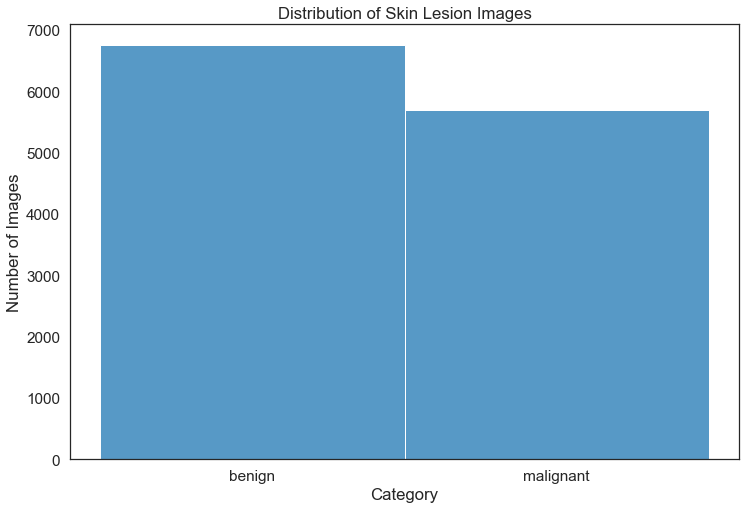

In [83]:
# Creating a histogram to visualize the classes:
plt.figure(figsize=(12,8))
sns.set_theme(style="white", palette=None, font_scale=1.4)
sns.histplot(data=df_copy, x="benign_malignant")
plt.ylabel("Number of Images")
plt.xlabel("Category")
plt.title('Distribution of Skin Lesion Images');

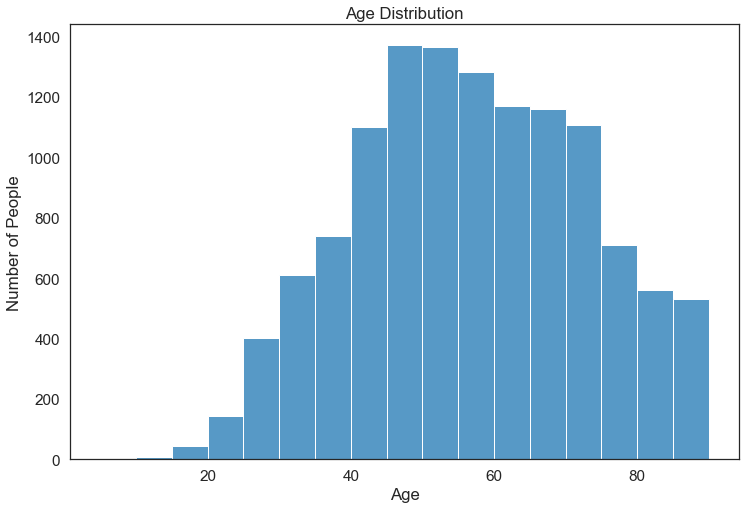

In [84]:
# Creating a histogram to visualize age distribution
plt.figure(figsize=(12,8))
sns.set_theme(style="white", palette=None, font_scale=1.4)
sns.histplot(data=df_copy, x="age_approx", binwidth=5)
plt.ylabel("Number of People")
plt.xlabel("Age")
plt.title('Age Distribution');

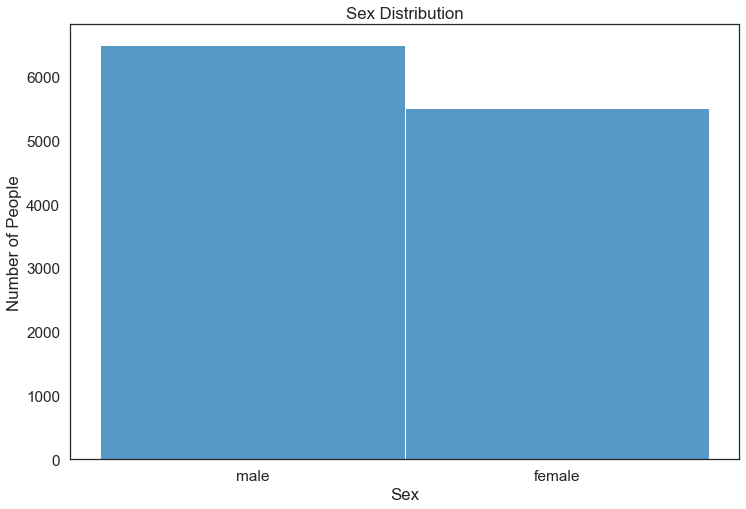

In [85]:
# Creating a histogram to visualize sex
plt.figure(figsize=(12,8))
sns.set_theme(style="white", palette=None, font_scale=1.4)
sns.histplot(data=df_copy.dropna(), x="sex")
plt.ylabel("Number of People")
plt.xlabel("Sex")
plt.title('Sex Distribution');

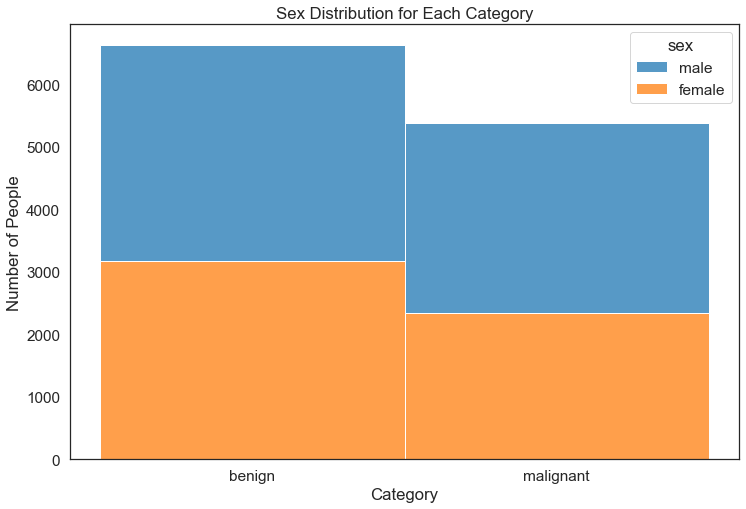

In [86]:
# Creating a histogram to visualize sex distribution for each category:
plt.figure(figsize=(12,8))
sns.set_theme(style="white", palette=None, font_scale=1.4)
sns.histplot(data=df_copy.dropna(), x="benign_malignant", hue="sex",  multiple="stack")
plt.ylabel("Number of People")
plt.xlabel("Category")
plt.title('Sex Distribution for Each Category');

## 5. Data Preperation

In [34]:
# Calling in the final dataset:
df_final

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12431,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg
12432,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg
12433,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg
12434,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,2018 JID Editorial Images,jpg


In [35]:
# Define X and y 
X = df_final[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df_final['benign_malignant']

In [36]:
X

,image_name,path,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,45.0,head/neck
1,ISIC_0015719,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,45.0,upper extremity
2,ISIC_0052212,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,50.0,lower extremity
3,ISIC_0068279,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,45.0,head/neck
4,ISIC_0074268,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,55.0,upper extremity
...,...,...,...,...,...
12431,ISIC_0024302,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,female,25.0,NaN
12432,ISIC_0024303,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,male,60.0,NaN
12433,ISIC_0024304,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,male,70.0,NaN
12434,ISIC_0024305,data/ISIC_IMAGES_512x512/Add_ISIC/image_add/IS...,male,85.0,NaN


In [37]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [38]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [39]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       4845
malignant    4108
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
2034,ISIC_0714807,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,20.0,upper extremity,benign
6216,ISIC_1984995,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,30.0,palms/soles,benign
1848,ISIC_0663588,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,65.0,torso,benign
11624,ISIC_0071693,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,40.0,head/neck,malignant
4775,ISIC_1558731,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,45.0,torso,benign
...,...,...,...,...,...,...
2578,ISIC_0884397,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,40.0,torso,benign
11825,ISIC_0072990,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,50.0,anterior torso,malignant
672,ISIC_0307958,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,80.0,palms/soles,benign
6213,ISIC_1984152,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,55.0,torso,benign


In [40]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Test dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Test dataset: 
 benign       1211
malignant    1028
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
8227,ISIC_0028219,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,male,45.0,upper extremity,malignant
3879,ISIC_1289942,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,60.0,torso,benign
2819,ISIC_0954236,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,45.0,lower extremity,benign
11196,ISIC_0068438,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,75.0,palms/soles,malignant
1808,ISIC_0652205,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,40.0,lower extremity,benign
...,...,...,...,...,...,...
10278,ISIC_0062029,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,80.0,anterior torso,malignant
5484,ISIC_1768051,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,70.0,lower extremity,benign
4342,ISIC_1431236,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,55.0,torso,benign
3993,ISIC_1326366,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,65.0,lower extremity,benign


In [41]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       694
malignant    550
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10405,ISIC_0062914,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,50.0,lower extremity,malignant
6392,ISIC_2038024,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,45.0,lower extremity,benign
1483,ISIC_0552960,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,60.0,lower extremity,benign
4190,ISIC_1384527,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,female,35.0,lower extremity,benign
8635,ISIC_0032724,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,50.0,posterior torso,malignant
...,...,...,...,...,...,...
8450,ISIC_0030929,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,55.0,upper extremity,malignant
4949,ISIC_1611285,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,30.0,lower extremity,benign
2239,ISIC_0772957,data/ISIC_IMAGES_512x512/ISIC2020/image2020/IS...,male,45.0,torso,benign
10402,ISIC_0062891,data/ISIC_IMAGES_512x512/ISIC2019/image2019/IS...,female,35.0,anterior torso,malignant


We have 8953 images with 4845 benign and 4108 malignant classes for training purpose. We have 2239 images with 1211 benign and 1028 malignant classes for validation purpose. We also set aside test/holdout set for final evaluation which has 1244 images with 694 benign and 550 malignant classes.

## 6. Image Preprocessing

In this section, the images will be prepared for modeling. ImageDataGenerator will be used to normalize RGB values of each image and all images will be resized into 64x64 image size. Image labels will also be created for training, validation and test set in this section.

In [42]:
# Instantiate a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Create the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_train),
                                                seed=42,
                                                class_mode='binary')


# Create the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 64x64
                                              target_size=(64, 64),
                                              batch_size=len(df_val),
                                              seed=42,
                                              class_mode='binary')


# Set aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_test),
                                                seed=42,
                                                class_mode='binary')

Found 8953 validated image filenames belonging to 2 classes.
Found 2239 validated image filenames belonging to 2 classes.
Found 1244 validated image filenames belonging to 2 classes.


In [43]:
# Look into class indices 
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [44]:
# Create image and labels data sets by using next() fnc:
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

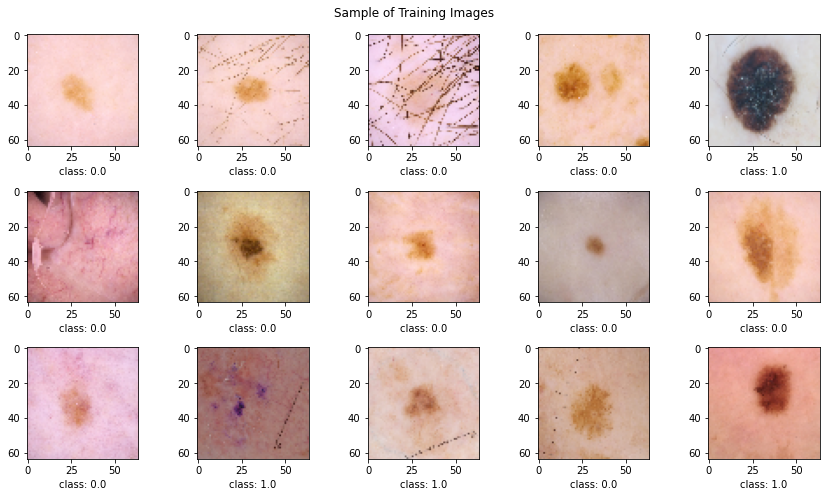

In [45]:
# Visualize sample of Training images:
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for i in range(15):
    img = train_images[i]
    ax = axes[i//5, i%5]
    ax.imshow(img, aspect='equal')
    ax.set_xlabel(f'class: {train_labels[i]}')

fig.suptitle('Sample of Training Images')
plt.tight_layout()
plt.show()

In [46]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


In [47]:
# Explore dataset again
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of test samples: " + str(m_test))

print ("train_images shape: " + str(train_images.shape))   
print ("train_labels shape: " + str(train_labels.shape))

print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 8953
Number of validation samples: 2239
Number of test samples: 1244
train_images shape: (8953, 64, 64, 3)
train_labels shape: (8953,)
val_images shape: (2239, 64, 64, 3)
val_labels shape: (2239,)
test_images shape: (1244, 64, 64, 3)
test_labels shape: (1244,)


In [48]:
# Reshaping image sets:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(8953, 12288)
(2239, 12288)
(1244, 12288)


## 7. Modeling

In the modeling part of this project, I started baseline with multi-layer perceptron, and then trained various CNNs by trying to hypertune the model to get best accuracy and recall score. The CNN modeling iterations are showed explicitly in the [Image_Processing_and_Modeling](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Image_Processing_and_Modeling.ipynb) notebook. In order to implement CNN models to skin lesions dataset, Flatiron school's [CNN codealong notebook](https://github.com/learn-co-curriculum/dsc-convolutional-neural-networks-codealong) is used as a reference.

Also I used pre-trained VGG16 model and did two iteration by building different dense layers after the pre-trained VGG16 model layers to increase accuracy and recall scores. Pre-trained modeling iterations are done in [Transfer_Learning_Models](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Transfer_Learning_Models.ipynb) notebook in detail.  

In the compiling part of the all modeling done in this project, I decided to use 'sgd' optimizer. The reason behind this choise is that one recent research article, named [Train faster, generalize better: Stability of stochastic gradient descent](http://proceedings.mlr.press/v48/hardt16.pdf), showed that SGD (Stochastic Gradient Descent) optimizer generalizes better than Adam optimizer, i.e. has less generalization (out-of-sample) error. Since the goal of this project to predict skin lesions classes accurately for previously unseen data, SGD optimizer will be used in all the model iterations throughout this project. 

## 7.1. Modeling with Neural Networks

The training part of CNN modeling iterations can be found in [Image_Processing_and_Modeling](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Image_Processing_and_Modeling.ipynb) notebook in details. Here I will represent the summary of the models along with training and validation scores.

### 7.1.1 Baseline - Multilayer Perceptron

In [49]:
# Load the model:
baseline = load_model('Saved_Models/baseline_model.h5')
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                245780    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                252       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 246,103
Trainable params: 246,103
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Load modeling results:
baseline_scores = pd.read_csv('Saved_Models/baseline_results.csv')
baseline_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.325581,0.842846,0.693281,0.950918,0.939903
1,0.373363,0.824922,0.665370,0.934426,0.920131


**Analysis:** We got 84% accuracy for training and 82% accuracy for validation set for baseline model.

### 7.1.2 Convolutional Neural Network

#### First Iteration

In [51]:
# Load the model:
cnn1 = load_model('Saved_Models/cnn_model.h5')
cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [52]:
# Load modeling results:
cnn1_scores = pd.read_csv('Saved_Models/cnn_results.csv')
cnn1_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.253835,0.891991,0.816943,0.939793,0.965246
1,0.321512,0.866458,0.788911,0.908175,0.944406


**Analysis:** The First CNN model has improved accuracy results compared to the baseline model, multi-layer perceptron. We got 89% accuracy for training and 86% accuracy for validation set. We will continue iterating on CNN model to improve model accuracy and recall scores.

#### Second Iteration

To improve the modeling results of baseline and cnn1 model, I began iterating on convolutional neural networks. I will try adding more convolutional and batch normalization layers to improve model performance.

In [53]:
# Load the model:
cnn2 = load_model('Saved_Models/cnn2_model.h5')
cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 256)       7168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        147520    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 32)       

In [54]:
# Load modeling results:
cnn2_scores = pd.read_csv('Saved_Models/cnn2_results.csv')
cnn2_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.527665,0.768346,0.991723,0.666340,0.968038
1,0.604719,0.761054,0.977626,0.662492,0.944324


**Analysis:** Adding one convolutional and batch normalizationa layers result in decrease in accuracy. But, we got great recall score. We need to train more complex model, so we will add more pooling and convolution layers.

#### Third Iteration

In [55]:
# Load the model:
cnn3 = load_model('Saved_Models/cnn3_model.h5')
cnn3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)      

In [56]:
# Load modeling results:
cnn3_scores = pd.read_csv('Saved_Models/cnn3_results.csv')
cnn3_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.027157,0.990506,0.982473,0.996789,0.999655
1,0.439668,0.887896,0.832685,0.915508,0.942524


**Analysis:** Third iteration CNN model is overfitting. We have 99% accuracy score for training set, but 88% accuracy score for validation set. We will introduce L2 regularization parameter (l2=0.01) into the layers of the next model.

####  Fourth Iteration

In [57]:
# Load the model:
cnn4 = load_model('Saved_Models/cnn4_model.h5')
cnn4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [58]:
# Load modeling results:
cnn4_scores = pd.read_csv('Saved_Models/cnn4_results.csv')
cnn4_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.287042,1.000000,1.000000,1.000000,1.000000
1,0.684264,0.891916,0.885214,0.880077,0.947028


**Analysis:** Introducing L2 regularization (l2=0.001) did not help the overfitting problem. We have perfect accuracy for train set, and 89% accuracy for validation set. We will add dropout layers and increase regularization effect by decreasing L2 parameter.

#### Fifth Iteration

In [59]:
# Load the model:
cnn5 = load_model('Saved_Models/cnn5_model.h5')
cnn5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)      

In [60]:
# Load modeling results:
cnn5_scores = pd.read_csv('Saved_Models/cnn5_results.csv')
cnn5_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.326513,0.956439,0.939387,0.964750,0.991342
1,0.533542,0.882090,0.855058,0.884306,0.954296


**Analysis:** Introducing L2 regularization (l2=0.0005) for layers and adding some dropout layers helped the overfitting problem a little. We have 95% accuracy for train set, and 88% accuracy for validation set. The accuracy score for validation set is not good enough. We will try data augmentation for training dataset in the next iteration.

#### Sixth Iteration

In [61]:
# Instantiating a data augmentation generator object for training set:
aug_generator = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=True)

# Creating the generator for the training data
aug_train_generator = aug_generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_train),
                                                seed=42,
                                                class_mode='binary')


Found 8953 validated image filenames belonging to 2 classes.


In [62]:
aug_train_images, aug_train_labels = next(aug_train_generator)

We fitted on the augmented training images when compiling the CNN model.

In [63]:
# Load the model:
cnn6 = load_model('Saved_Models/cnn6_model.h5')
cnn6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 256)       7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       1

In [64]:
# Load modeling results:
cnn6_scores = pd.read_csv('Saved_Models/cnn6_results.csv')
cnn6_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.541011,0.895789,0.830575,0.935051,0.963602
1,0.586527,0.880750,0.806420,0.924192,0.952053


**Analysis:** This model took 5 hours to run on a local computer, and accuracy and recall scores of validation dataset did not improve as much compared to cnn4_model results. I will choose cnn4_model for my final 'best' CNN model so far.

## 7.2. Modeling with Pre-Trained Models

The trainng part of pre-trained modeling iterations can be found in [Transfer_Learning_Models](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Transfer_Learning_Models.ipynb) notebook in details. Here I will represent the summary of the models along with training and validation scores.

### 7.2.1 VGG16 Models

#### First Iteration

In [65]:
# Load the model:
model1_vgg16 = load_model('Saved_Models/model1_vgg16_final.h5')
model1_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 14,987,329
Trainable params: 272,641
Non-trainable params: 14,714,688
____________________________________

In [66]:
# Load modeling results:
model1_vgg16_scores = pd.read_csv('Saved_Models/model1_vgg16_results.csv')
model1_vgg16_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.257814,0.887300,0.820837,0.925103,0.960289
1,0.308099,0.866458,0.798638,0.899233,0.942421


**Analysis:** This VGG16 model got 88% accuracy for training set and 86% accuracy for validation set. Also recall scores are not very good, 82% for training set and 79% for validation set. I will try another VGG16 model with more complex dense layers.

#### Second Iteration

In [67]:
# Load the model:
model2_vgg16 = load_model('Saved_Models/model2_vgg16_final.h5')
model2_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                65568     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [68]:
# Load modeling results:
model2_vgg16_scores = pd.read_csv('Saved_Models/model2_vgg16_results.csv')
model2_vgg16_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.376575,0.943594,0.895326,0.980016,0.990943
1,0.635351,0.876284,0.804475,0.915836,0.938486


**Analysis:** This VGG16 model got 94% accuracy for training set and 87% accuracy for validation set. This model is better than first VGG16 model defined above. I will choose Model2_VGG16 for final evaluation of the pre-trained models.

## 8. Evaluation

### 8.1. CNN Evaluation

In [69]:
# Load final CNN model:
final_CNN_model = load_model('Saved_Models/cnn4_model.h5')

In [70]:
final_CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       7

In [71]:
final_CNN_training_scores = pd.read_csv('Saved_Models/cnn4_results.csv')
final_CNN_training_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.287042,1.000000,1.000000,1.000000,1.000000
1,0.684264,0.891916,0.885214,0.880077,0.947028


I will use this final CNN model to evaluate the test/holdout set scores.

In [72]:
# Test/Holdout set scores:
final_CNN_score = final_CNN_model.evaluate(test_images, test_labels)

39/39 [==============================] - 1s 26ms/step - loss: 0.5627 - accuracy: 0.9148 - recall_9: 0.9055 - precision_9: 0.9022 - auc_9: 0.9664


In [89]:
print("%s: %.2f%%" % (final_CNN_model.metrics_names[1], final_CNN_score[1]*100))
print("%s: %.2f%%" % (final_CNN_model.metrics_names[2][:-2], final_CNN_score[2]*100))

accuracy: 91.48%
recall: 90.55%


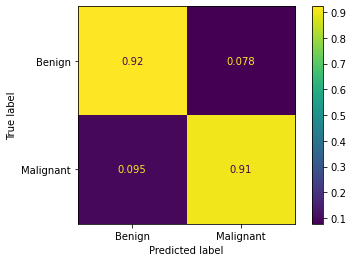

In [74]:
# Plot confusion matrix with percentages:
test_predictions = (final_CNN_model.predict(test_images) > 0.5).astype("int32")
test_cm = confusion_matrix(test_labels, test_predictions, normalize='true')
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Benign', 'Malignant'])
test_disp.plot()
plt.show()

### 8.2. VGG16 Evaluation

In [75]:
# Load final VGG16 model:
final_vgg16_model = load_model('Saved_Models/model2_vgg16_final.h5')

In [76]:
final_vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                65568     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [77]:
final_vgg16_training_scores = pd.read_csv('Saved_Models/model2_vgg16_results.csv')
final_vgg16_training_scores

,Loss,Accuracy,Recall,Precision,AUC
0,0.376575,0.943594,0.895326,0.980016,0.990943
1,0.635351,0.876284,0.804475,0.915836,0.938486


I will use this final VGG16 model to evaluate the test/holdout set scores.

In [78]:
# Test/Holdout set scores:
final_vgg16_score = final_vgg16_model.evaluate(test_images, test_labels)

39/39 [==============================] - 20s 518ms/step - loss: 0.5455 - accuracy: 0.8891 - recall_10: 0.8182 - precision_10: 0.9221 - auc_10: 0.9585


In [90]:
print("%s: %.2f%%" % (final_vgg16_model.metrics_names[1], final_vgg16_score[1]*100))
print("%s: %.2f%%" % (final_vgg16_model.metrics_names[2][:-3], final_vgg16_score[2]*100))

accuracy: 88.91%
recall: 81.82%


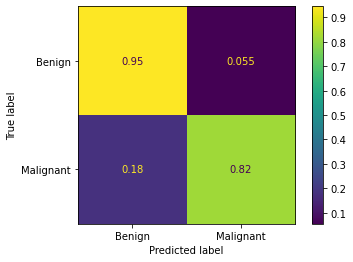

In [80]:
# Plot confusion matrix with percentages:
test_predictions = (final_vgg16_model.predict(test_images) > 0.5).astype("int32")
test_cm = confusion_matrix(test_labels, test_predictions, normalize='true')
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Benign', 'Malignant'])
test_disp.plot()
plt.show()

### 8.3. Final Evaluation

When we look at the results of the CNN evaluation and VGG16 evaluation scores, it is seen that CNN model has better accuracy and recall score compared to pre-trained VGG16 model. Therefore the final model is chosen to be  **final_CNN_model**  with 91% accuracy and 90% recall scores.

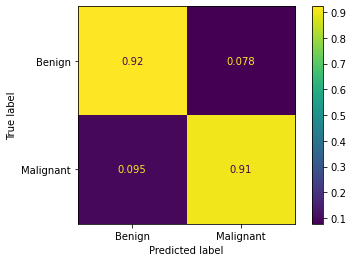

In [81]:
# Plot confusion matrix with percentages:
test_predictions = (final_CNN_model.predict(test_images) > 0.5).astype("int32")
test_cm = confusion_matrix(test_labels, test_predictions, normalize='true')
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Benign', 'Malignant'])
test_disp.plot()
plt.show()

In [91]:
print("%s: %.2f%%" % (final_CNN_model.metrics_names[1], final_CNN_score[1]*100))
print("%s: %.2f%%" % (final_CNN_model.metrics_names[2][:-2], final_CNN_score[2]*100))

accuracy: 91.48%
recall: 90.55%


## 9. Conclusion

## 10. Next Steps